In [1]:
import pandas as pd
import numpy as np
import os
import warnings
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Configuration ---
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("- Necessary libraries imported.")

- Necessary libraries imported.


In [2]:
# --- Configuration ---
# Use a relative path for the data file
DATA_FILE = "Input_data.csv"
MODEL_OUTPUT_PATH = "random_forest_model_best.pkl"

# --- Load Data ---
try:
    input_data = pd.read_csv(DATA_FILE)
    print(f"- Successfully loaded data from {DATA_FILE}")
    print(f"  Initial data shape: {input_data.shape}")
    print("  Data preview:")
    print(input_data.head())
    data_loaded = True

except FileNotFoundError:
    print(f"- Error: Data file not found at {DATA_FILE}")
    print("  Please make sure the file is in the same directory as this notebook.")
    data_loaded = False
except Exception as e:
    print(f"- An unexpected error occurred: {e}")
    data_loaded = False

- Successfully loaded data from Input_data.csv
  Initial data shape: (1661, 8)
  Data preview:
   ID State_t-5 State_t-4 State_t-3 State_t-2 State_t-1  State_t  \
0   1   outside   outside   outside   outside   outside  outside   
1   2   outside   outside   outside   outside   outside  outside   
2   3      stay      stay      stay      stay      stay     stay   
3   4      stay      stay      stay      stay   outside     stay   
4   5      stay      stay      stay   outside   outside     stay   

  State_predicted  
0         outside  
1         outside  
2         outside  
3         outside  
4         outside  


In [3]:
if data_loaded:
    # --- 1. Define Mappings ---
    # We need to convert the string states (e.g., 'stay', 'outside') into numbers for the model.
    # Map for Features (History States)
    STATE_TO_NUMERIC = {
        "arrival": 0,
        "stay": 1,
        "leave": 2,
        "outside": 3
    }

    # Map for Target (Correction Logic)
    # The RF model predicts: Should we correct this to 'IN' (1) or keep it 'OUT' (0)?
    # Real State 'stay'/'arrival' -> 1 (Correction needed: Change 'outside' to 'stay')
    # Real State 'outside'/'leave' -> 0 (No correction needed: Keep 'outside')
    TARGET_MAPPING = {
        "arrival": 1, 
        "stay": 1,     
        "leave": 0,    
        "outside": 0   
    }

    # --- 2. Encode Features ---
    # The features are the explicit history columns provided in the CSV
    feature_cols = ['State_t-5', 'State_t-4', 'State_t-3', 'State_t-2', 'State_t-1']
    
    # Create a copy to avoid SettingWithCopy warnings
    X_raw = input_data[feature_cols].copy()
    
    # Apply mapping to all feature columns
    for col in feature_cols:
        X_raw[col] = X_raw[col].map(STATE_TO_NUMERIC)
        
    # Check for unmapped values (NaNs)
    if X_raw.isnull().values.any():
        print("- Warning: NaN values found in features after mapping. Dropping these rows.")
        X_raw = X_raw.dropna()
        # Align indices with target
        input_data = input_data.loc[X_raw.index]

    X = X_raw

    # --- 3. Encode Target ---
    # The target is based on the 'State_t' (Real State) column
    y = input_data['State_t'].map(TARGET_MAPPING)
    
    # Check for unmapped targets
    if y.isnull().values.any():
        print("- Warning: NaN values found in target after mapping. Dropping these rows.")
        valid_indices = y.dropna().index
        X = X.loc[valid_indices]
        y = y.loc[valid_indices]

    print("- Feature engineering complete.")
    print(f"  Features (X) shape: {X.shape}")
    print(f"  Target (y) shape: {y.shape}")
    print(f"  Class distribution in target: \n{y.value_counts()}")

else:
    print("- Skipping feature engineering because data was not loaded.")

- Feature engineering complete.
  Features (X) shape: (1661, 5)
  Target (y) shape: (1661,)
  Class distribution in target: 
0    1495
1     166
Name: State_t, dtype: int64


In [4]:
if data_loaded and 'X' in locals() and not X.empty:
    # Split the data into training and testing sets
    # 'stratify=y' ensures both train and test sets have a similar proportion of correction cases
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    
    print("- Data split into training and testing sets.")
    print(f"  X_train shape: {X_train.shape}")
    print(f"  y_train shape: {y_train.shape}")
    print(f"  X_test shape:  {X_test.shape}")
    print(f"  y_test shape:  {y_test.shape}")
else:
    print("- Skipping train/test split because data was not processed.")

- Data split into training and testing sets.
  X_train shape: (1328, 5)
  y_train shape: (1328,)
  X_test shape:  (333, 5)
  y_test shape:  (333,)


In [5]:
# --- Define Parameter Grid for Grid Search ---
param_grid = {
    'n_estimators': [50, 100, 150],       # Number of trees in the forest
    'max_depth': [5, 10, 15, 20],         # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],        # Minimum samples required at a leaf node
    'class_weight': ['balanced'],         # Handle potential class imbalance
}

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='accuracy',  # Use accuracy as the evaluation metric
    cv=5,                # Number of cross-validation folds
    verbose=0,           # Suppress verbose output
    n_jobs=-1            # Use all available CPU cores
)

print("- Random Forest model and GridSearchCV defined.")

- Random Forest model and GridSearchCV defined.


In [6]:
if 'X_train' in locals() and not X_train.empty:
    print("- Starting GridSearchCV for hyperparameter tuning...")
    
    # Run the grid search
    grid_search.fit(X_train, y_train)
    
    # --- Show GridSearch Results ---
    print("  GridSearch Results:")
    print(f"  Best Parameters: {grid_search.best_params_}")
    print(f"  Best Cross-Validation Score (Accuracy): {grid_search.best_score_:.4f}")
    
    print("- Model training and grid search complete.")
else:
    print("- Training skipped because data was not split.")

- Starting GridSearchCV for hyperparameter tuning...
  GridSearch Results:
  Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  Best Cross-Validation Score (Accuracy): 0.9292
- Model training and grid search complete.


In [7]:
if 'grid_search' in locals():
    print("- Evaluating the best model on the test set...")
    
    # Get the best model found by the grid search
    best_rf_model = grid_search.best_estimator_
    
    # Make predictions on the test set
    y_pred = best_rf_model.predict(X_test)

    # --- Calculate Evaluation Metrics ---
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['No Correction (0)', 'Correct to Stay (1)'])

    # --- Display Evaluation Results ---
    print("  Model Evaluation Results (Test Set):")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Confusion Matrix: \n{conf_matrix}")
    print(f"  Classification Report: \n{class_report}")
    
    print("- Model evaluation complete.")
else:
    print("- Evaluation skipped because the model was not trained.")

- Evaluating the best model on the test set...
  Model Evaluation Results (Test Set):
  Accuracy: 0.9670
  Confusion Matrix: 
[[298   2]
 [  9  24]]
  Classification Report: 
                     precision    recall  f1-score   support

  No Correction (0)       0.97      0.99      0.98       300
Correct to Stay (1)       0.92      0.73      0.81        33

           accuracy                           0.97       333
          macro avg       0.95      0.86      0.90       333
       weighted avg       0.97      0.97      0.97       333

- Model evaluation complete.


- Generating confusion matrix plot...


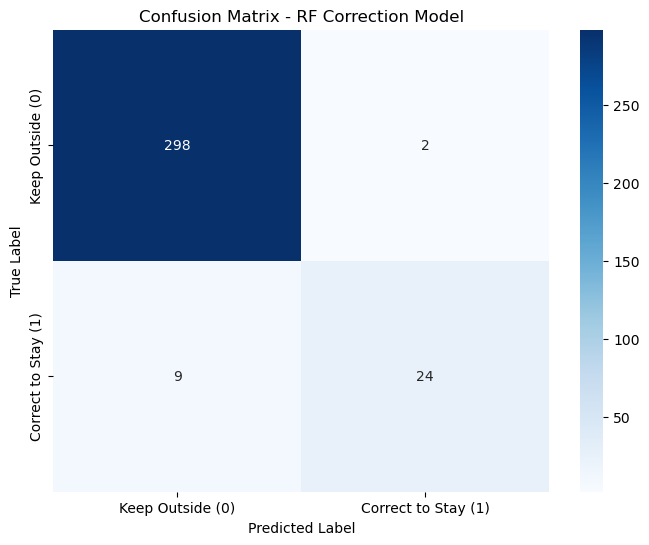

- Confusion matrix plot generated.


In [8]:
# This cell provides a visual representation of the confusion matrix
if 'conf_matrix' in locals():
    print("- Generating confusion matrix plot...")
    
    # Define class labels for the plot
    class_labels = ['Keep Outside (0)', 'Correct to Stay (1)']

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix, 
        annot=True,     # Show numbers inside the cells
        fmt='d',        # Format as integers
        cmap='Blues',   # Color map
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix - RF Correction Model')
    plt.show()
    
    print("- Confusion matrix plot generated.")
else:
    print("- Plotting skipped because the confusion matrix was not calculated.")

In [9]:
if 'grid_search' in locals():
    # Save the best model (best_estimator_) found by Grid Search
    joblib.dump(grid_search.best_estimator_, MODEL_OUTPUT_PATH)
    
    print(f"- Best model saved to: {MODEL_OUTPUT_PATH}")
    print("- Final model saved to disk.")
else:
    print("- Model saving skipped because the model was not trained.")

- Best model saved to: random_forest_model_best.pkl
- Final model saved to disk.
